This notebook is a first attempt to translate the FORTRAN90 code from MTV2016 into python
and to replicate the main results of this paper.

In [1]:
import numpy as np
from scipy.stats import lognorm

import matplotlib.pyplot as plt
plt.style.use(['dark_background'])

In [2]:
#Paramters for the piece-rate version

delta = 0.000226
lamb_e = 0.7048178
k = 22.9931
sigma_z = 0.0
rhorho1 = 4.296953
rho2 = 0.065518
zlearningprob = 0.26398515
b = 2.3105359
theta9 = 0.0
theta10 = 0.0
zshockprob = 0.0093854   


#    IF (npar>=10) THEN
#    rho3=theta(9)  
#    rho4=theta(10)  
#    ELSE IF (npar==8) THEN
#    rho3=0.0_8
#    rho4=0.0_8
#    ELSE 

In [26]:
# Match shock z.
# First, populating the match productivity shock vector, if zpts_first is >1

zpts_first = 102 # basic grid. 102 in MTV2016

zpts = zpts_first

# zvector are the actual values of the match quality, dim(zpts)
# ztransmatrix is the transition matrix, dim(zpts, zpts)

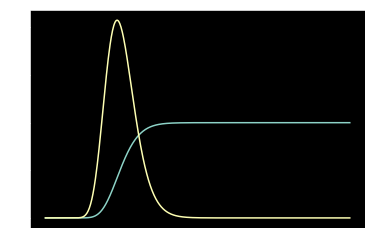

In [6]:
sigma_z = 0.2
mu_temp = np.exp(-0.5 * sigma_z**2) # this guarantess that the mean of the distribution is 1

x = np.linspace(0, 4, 500)
plt.plot(x, lognorm.cdf(x, sigma_z, loc=0, scale=mu_temp))
plt.plot(x, lognorm.pdf(x, sigma_z, loc=0, scale=mu_temp))
plt.show()

# print(lognorm.cdf(0.3, shape, loc=0, scale=mu_temp))
# tempreal = 0.8 * xstep * lognorm.cdf(0.3, shape, loc=0, scale=mu_temp)
# tempreal

In [18]:
lognorm.pdf(0.001, 0.2, loc=0, scale=mu_temp)

5.713281672824242e-255

In [38]:
# Obtain a discrete LOGNORMAL probability distr for z

zprobcdf = np.empty((zpts))
zprobpdf = np.empty((zpts))
zvector = np.empty((zpts))

sigma_z = 0.2 # CHANGE OF PARAMTER: sigma_z must be positive
mu_temp = np.exp(-0.5 * sigma_z**2) # mean of the lognormal distr, s.t. mean of the distr is 1
binsize = 1 / (zpts - 1) # binsize

shape = sigma_z

resolution = 10000
xstep = 1 / resolution # keep stepping, Resolution should be much higher than no. of bins (resolution=10000)

xvalue = xstep # move along the interval of z's, starting close to 1
tempreal = 0.8 * xstep * lognorm.cdf(xvalue, shape, loc=0, scale=mu_temp) # this value is used to weight the z-values
# properly within the bin
bincounter = 1 # start with the first bin

# zprobcdf contains the probabilities of the idiosyncratic shock, dim zpts

# First fill all but the last coordinate
while bincounter < zpts:
    if lognorm.cdf(xvalue, shape, loc=0, scale=mu_temp) >= (bincounter * binsize): # if the bin is full..
        zprobcdf[bincounter - 1] = lognorm.cdf(xvalue, shape, loc=0, scale=mu_temp) # add to the cdf
        if bincounter == 1:
            zprobpdf[bincounter - 1] = zprobcdf[bincounter - 1]
            zvector[bincounter - 1] = tempreal / zprobpdf[bincounter - 1]
        else:
            zprobpdf[bincounter - 1] = zprobcdf[bincounter - 1] - zprobcdf[bincounter - 2]
            zvector[bincounter - 1] = tempreal / zprobpdf[bincounter - 1]
        
        tempreal = 0 # reset the average counter 
        bincounter += 1
        
        while lognorm.cdf(xvalue, shape, loc=0, scale=mu_temp) >= (bincounter * binsize):
            zvector[bincounter - 1] = xstep
            zprobcdf[bincounter - 1] = lognorm.cdf(xvalue, shape, loc=0, scale=mu_temp)
            zprobpdf[bincounter - 1] = 0
            bincounter += 1
            
    else:
        while lognorm.cdf(xvalue, shape, loc=0, scale=mu_temp) < (bincounter * binsize):
            xvalue = xvalue + xstep
            tempreal = tempreal + (xvalue - 0.5 * xstep) * (lognorm.cdf(xvalue, shape, loc=0, scale=mu_temp) \
                                                        - lognorm.cdf(xvalue - xstep, shape, loc=0, scale=mu_temp))
# # last gridpoint
# tempreal = 0
# xstep = xvalue / (zpts * 5)

# counter1 = 1
# while counter1 < 11:
#     xvalue = xvalue + xstep
#     tempreal = tempreal + (xvalue - 0.5 * xstep) * (lognorm.cdf(xvalue, shape, loc=0, scale=mu_temp) \
#                                                         - lognorm.cdf(xvalue - xstep, shape, loc=0, scale=mu_temp))
#     counter1 += 1
    
zvector[zpts-1] = tempreal / (lognorm.cdf(xvalue, shape, loc=0, scale=mu_temp) - zprobcdf[zpts - 2])
zprobcdf[zpts-1] = 1
zprobpdf[zpts-1] = 1 - zprobcdf[zpts - 2]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars


In [45]:
zprobcdf

array([0.00990698, 0.01980648, 0.02974805, 0.0396644 , 0.04955272,
       0.05947277, 0.06938223, 0.07923184, 0.08919173, 0.09910311,
       0.10893479, 0.11881784, 0.12880442, 0.13869252, 0.14855168,
       0.15847621, 0.168427  , 0.17836628, 0.18825793, 0.19806757,
       0.20793472, 0.21783937, 0.22776213, 0.23768432, 0.24758799,
       0.25745601, 0.26746212, 0.27740545, 0.28727089, 0.29704422,
       0.30710852, 0.31686155, 0.3268903 , 0.33678623, 0.34653815,
       0.35654522, 0.36639199, 0.37627534, 0.38618846, 0.39612456,
       0.40607695, 0.41603897, 0.42579646, 0.43575829, 0.4457105 ,
       0.45564682, 0.46535485, 0.47544745, 0.48529992, 0.49511282,
       0.5050836 , 0.51500164, 0.5248614 , 0.53465752, 0.5445826 ,
       0.55462691, 0.56439141, 0.57426164, 0.58422725, 0.59408886,
       0.60402829, 0.61403437, 0.62391387, 0.63384175, 0.64362965,
       0.65362162, 0.66345512, 0.67329477, 0.68329353, 0.69310577,
       0.70304604, 0.71293662, 0.7229168 , 0.73281519, 0.74261

In [ ]:
# UNIFORM distr of z shocks

tempreal = 1 / (zpts - 1)
zprobpdf(2:zpts) = tempreal

tempreal2 = 1 / (zpts - 2)
zvector = 0.5 
zprobcdf(2) = zprobpdf(2)

for zcnt in range(3, zpts+1):
    zvector(zctn) = zvector(zctn - 1) + tempreal2
    zprobcdf(zctn) = zprobcdf(zctn - 1) + tempreal
    zctn += 1